### Task 51 Compulsory Task 1

In [84]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import normalize

from sklearn.decomposition import PCA #run again if it does not converge the first time
from pca import pca

from sklearn.metrics import accuracy_score, silhouette_score

from sklearn.cluster import AgglomerativeClustering
from sklearn.cluster import KMeans
from scipy.cluster.hierarchy import dendrogram, linkage
import scipy.cluster.hierarchy as shc

from scipy.spatial.distance import pdist
from scipy.spatial.distance import squareform



### Loading Dataset

In [85]:
us_arrest_df = pd.read_csv("USArrests.csv")

us_arrest_df.head()

,Unnamed: 0,Murder,Assault,UrbanPop,Rape
0,Alabama,13.2,236,58,21.2
1,Alaska,10.0,263,48,44.5
2,Arizona,8.1,294,80,31.0
3,Arkansas,8.8,190,50,19.5
4,California,9.0,276,91,40.6


### About This Report

Our DataFrame reveals that there are 5 features present. The information pertains to the number of arrests made per 100,000 residents for murder, assault, and rape crimes within each state.

The goal of this report is to use PCA and hierarchical clustering to show the relationship between crime and each state. We will use states as the response variable, and crime and population as the predictor variables to classify the data.

In [86]:
us_arrest_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50 entries, 0 to 49
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Unnamed: 0  50 non-null     object 
 1   Murder      50 non-null     float64
 2   Assault     50 non-null     int64  
 3   UrbanPop    50 non-null     int64  
 4   Rape        50 non-null     float64
dtypes: float64(2), int64(2), object(1)
memory usage: 2.1+ KB


### Cleaning Dataset

In order to prepare the dataset, the first step is to correct the data types, assign appropriate column name for the states, identify and handle any missing values, and finally, create a column for the total crime count.

In [87]:
# convert int data type to float
us_arrest_df["Assault"] = us_arrest_df["Assault"].astype(float)
us_arrest_df["UrbanPop"] = us_arrest_df["UrbanPop"].astype(float)

In [88]:
# fix column name for state 
us_arrest_df.rename(columns={"Unnamed: 0": "State"}, inplace=True)

In [89]:
# check for missing value in the dataset
us_arrest_df.isnull().sum()

State       0
Murder      0
Assault     0
UrbanPop    0
Rape        0
dtype: int64

In [90]:
# adding a total crime count  
us_arrest_df["Total Crime"] = us_arrest_df["Murder"] + us_arrest_df["Assault"] + us_arrest_df["Rape"]
us_arrest_df.head()


,State,Murder,Assault,UrbanPop,Rape,Total Crime
0,Alabama,13.2,236.0,58.0,21.2,270.4
1,Alaska,10.0,263.0,48.0,44.5,317.5
2,Arizona,8.1,294.0,80.0,31.0,333.1
3,Arkansas,8.8,190.0,50.0,19.5,218.3
4,California,9.0,276.0,91.0,40.6,325.6


In [91]:
# get statistics info on dataset
us_arrest_df.describe()

,Murder,Assault,UrbanPop,Rape,Total Crime
count,50.00000,50.000000,50.000000,50.000000,50.000000
mean,7.78800,170.760000,65.540000,21.232000,199.780000
std,4.35551,83.337661,14.474763,9.366385,93.372967
min,0.80000,45.000000,32.000000,7.300000,53.100000
25%,4.07500,109.000000,54.500000,15.075000,128.250000
50%,7.25000,159.000000,66.000000,20.100000,185.200000
75%,11.25000,249.000000,77.750000,26.175000,285.800000
max,17.40000,337.000000,91.000000,46.000000,382.300000


When conducting a PCA analysis, it is essential to consider the correlation between features, as it provides insight into how dimensionality reduction is achieved.

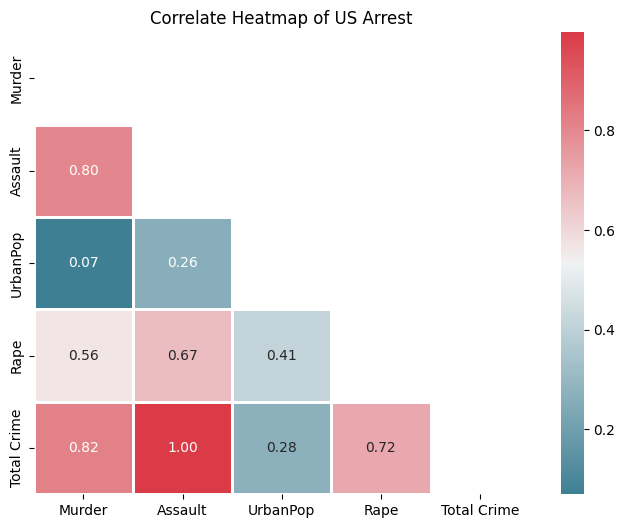

In [92]:
# get correlations
corrs = us_arrest_df.corr(numeric_only=True)

# set color palette
colormap = sns.diverging_palette(220, 10, as_cmap=True)

# Plot figsize
fig, ax = plt.subplots(figsize=(8, 6))

# to mask mirrored side of heatmap
dropSelf = np.zeros_like(corrs)
dropSelf[np.triu_indices_from(dropSelf)] = True

# Generate Heat Map, with annotations of the correlation strength and 2-decimal floats
ax = sns.heatmap(corrs, cmap=colormap, annot=True, fmt=".2f", mask=dropSelf, linewidth=2)

plt.title("Correlate Heatmap of US Arrest")
plt.show()

Comprehending the distribution of our data is crucial in generating accurate reports. Our data, as observed through descriptive statistical analysis, has features with varying ranges of values and certain difficulties in making comparisons. For example, UrbanPop is a percentage value of residents within each state, while number of murders, assaults, and rapes are distinct numeric values that are not expressed as percentages.

To further explore this assumption, we can visualize the distribution of each feature by using a boxplot. This will allow us to see the distribution pattern of the features.

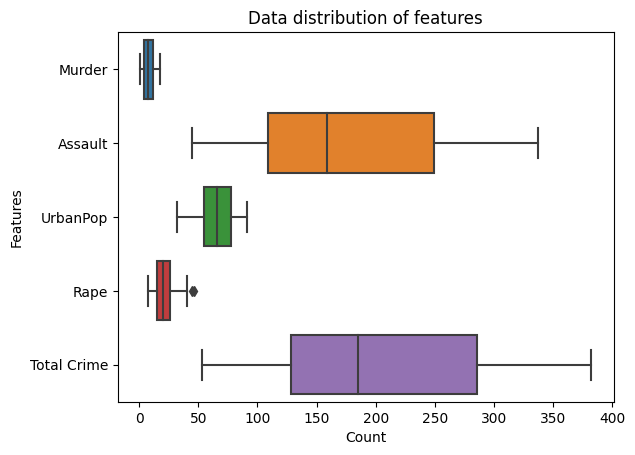

In [93]:
# feature distribution
sns.boxplot(us_arrest_df, orient='h')
plt.ylabel("Features")
plt.xlabel("Count")
plt.title("Data distribution of features")
plt.show()

### Data Scaling

To obtain an accurate analysis of our data, it is important to standardize each feature to the same range of values. Thus, scaling of the data is necessary.

In [94]:
# setup our X
X = us_arrest_df.drop(["State", "Total Crime"], axis=1)
# scaling dataset
X_scaled = StandardScaler().fit_transform(X)

us_arrest_scaled_df = pd.DataFrame(X_scaled, columns=us_arrest_df.columns[1:5])
us_arrest_scaled_df.head()

,Murder,Assault,UrbanPop,Rape
0,1.255179,0.790787,-0.526195,-0.003451
1,0.513019,1.118060,-1.224067,2.509424
2,0.072361,1.493817,1.009122,1.053466
3,0.234708,0.233212,-1.084492,-0.186794
4,0.281093,1.275635,1.776781,2.088814


### Selecting Number of Components for PCA

PCA enables us to identify the most important components within our dataset that are responsible for describing the underlying patterns. While a standard dataframe includes all features, PCA selects a smaller set of principal components that have the greatest impact on the outcome of interest.

When performing PCA, it is common to aim for a variance between 80% and 99% for the selected components. The minimum threshold for variance should not be lower than 60% as this can lead to biased and unreliable data. We can determine the minimum number of components required to reach this threshold through the use of scikit-learn.


In [95]:
# showing how each component attributes itself to the explained variance
pca = PCA().fit(us_arrest_scaled_df)

pca.explained_variance_ratio_

array([0.62006039, 0.24744129, 0.0891408 , 0.04335752])

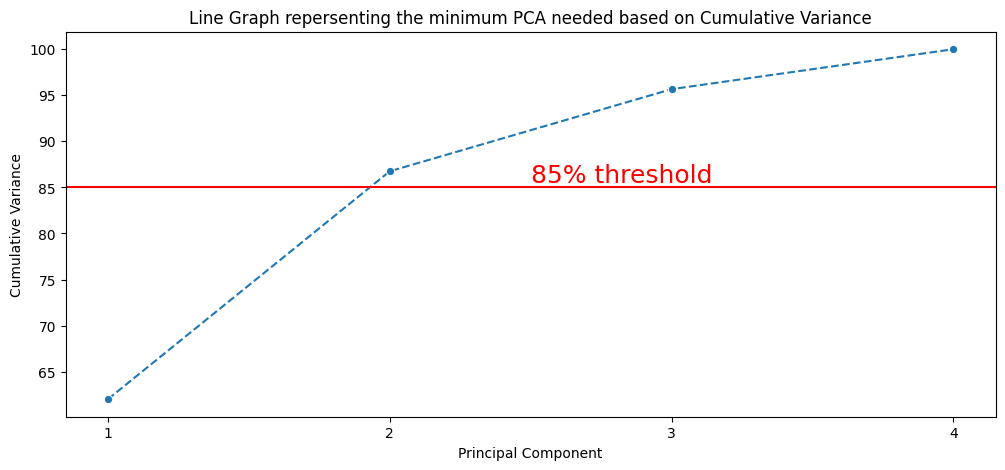

In [96]:
# creating a graph to show the minimum number of components needed for our analysis
X_range = np.arange(1, 5, step=1)

plt.figure(figsize=(12, 5))
sns.lineplot(x=X_range, y = np.cumsum(pca.explained_variance_ratio_) * 100, linestyle="--", marker='o')

plt.title("Line Graph repersenting the minimum PCA needed based on Cumulative Variance")
plt.xlabel("Principal Component")
# plt.xticks(np.arange(1, 5, step=1))
plt.xticks(X_range)
plt.ylabel("Cumulative Variance")
plt.axhline(y=85, color='r', linestyle='-')
plt.text(2.5, 85.5, "85% threshold", color="red", fontsize=18)
plt.show()

The above graph illustrates that component 1 explains 62% of the variance in our data, while component 2 explains 27.74%. Together, these two components account for 86.74% of the variance in the data. This means that by using only two principal components, we are able to retain a high level of explanation of the variance while reducing the number of features by 50%. With this information, we can proceed with our analysis and focus on working with these two components.

In [97]:
# proceeding with 2 components
pca_model = PCA(n_components=2)

principal_components = pca_model.fit_transform(X_scaled)

principal_components.shape

(50, 2)

[pca] >Column labels are auto-completed.
[pca] >Row labels are auto-completed.
[pca] >The PCA reduction is performed on the [4] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Outlier detection using Hotelling T2 test with alpha=[0.05] and n_components=[2]
[pca] >Outlier detection using SPE/DmodX with n_std=[2]
[pca] >Plot PC1 vs PC2 with loadings.


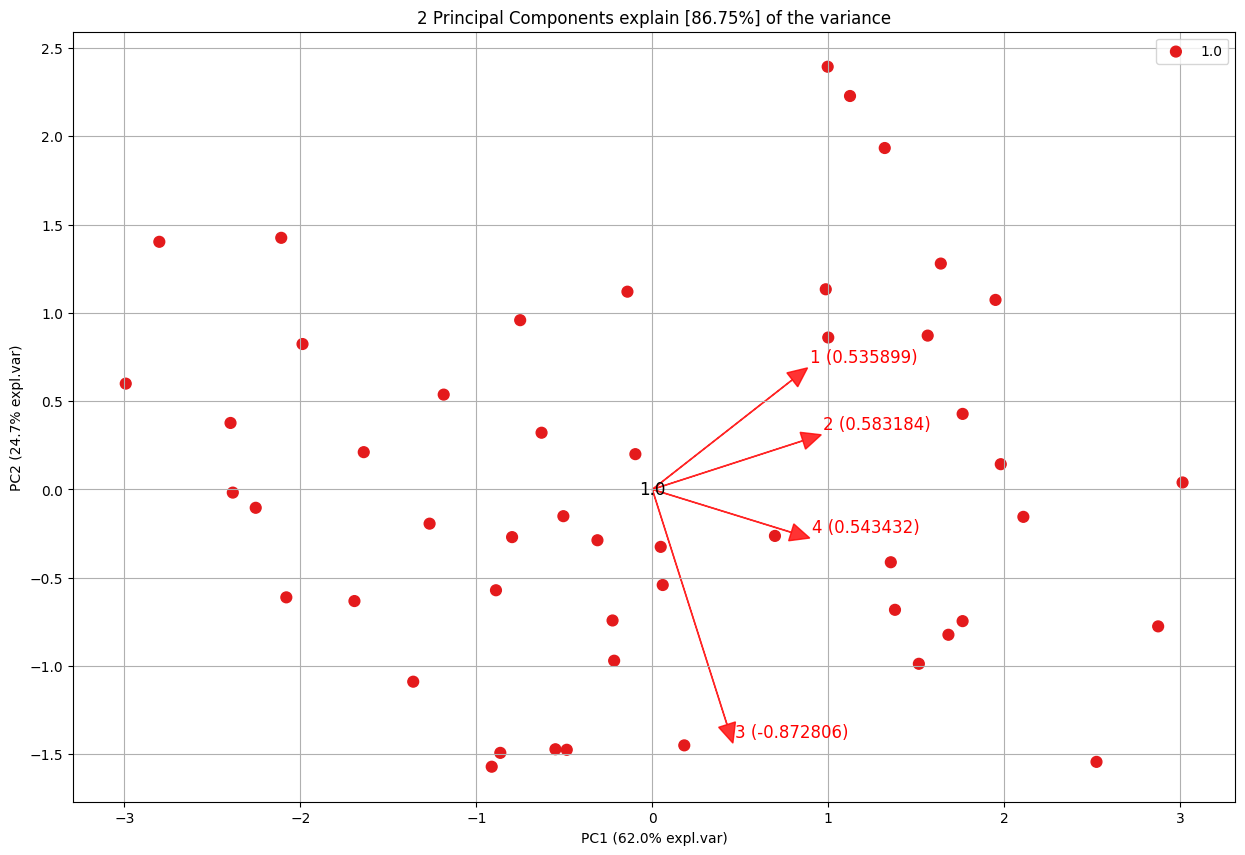

In [ ]:
# Create a biplot to represent components within the total dataframe

model = pca(n_components=2)

results = model.fit_transform(X_scaled)

# make biplot with the total number of features

fig, ax = model.biplot(n_feat=4, )

The illustration above displays the observations as points in a two-dimensional space defined by the principal components. The samples are depicted as points, and in this case, the different states are represented on the biplot. The vectors indicate the different variables, which in our data includes four variables: murder, assault, rape, and urban population. All of which are shown on the graph.

The variables represented on the graph have a positive correlation with the first principal component. The urban population variable, denoted as 3, has the highest correlation with the second principal component, and is the only variable with a negative correlation.

### Cluster Analysis

To gain a comprehensive understanding of the patterns in our data, we will apply both K-means and Hierarchical clustering techniques and compare their results.

### Elbow plots

The elbow point on the graph represents the optimal number of clusters, it is the point where the rate of decrease in the sum of squared distances begins to slow down. In our case, the graph indicates that the optimal number of clusters is 2, which aligns with the number of components identified in our PCA analysis.

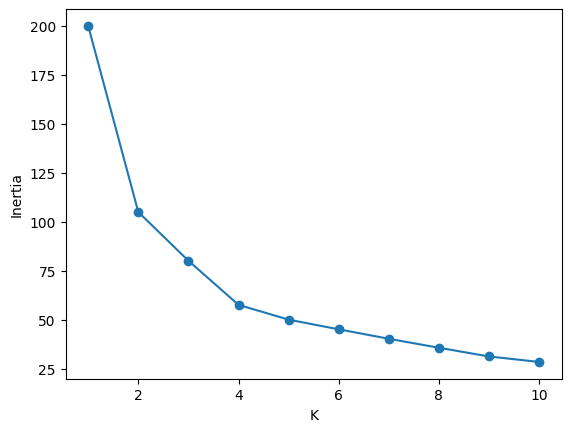

In [ ]:
def eval_Kmeans(x, k, r):
    kmeans = KMeans(n_clusters=k, random_state=r, n_init=10)
    kmeans.fit(x)    
    return kmeans.inertia_

def elbow_Kmeans(x, max_k=10, r=123):
    within_cluster_vars = [eval_Kmeans(x, k, r) for k in range(1,max_k+1)]
    plt.plot(range(1,11), within_cluster_vars,marker='o')
    plt.xlabel('K')
    plt.ylabel('Inertia')
    plt.show()

elbow_Kmeans(X_scaled)

### Silhouette Score

We can also use Silhouette Score to check the quality of the clustering, it is a measure of how similar an object is to its own cluster compared to other clusters. The score ranges from -1 to 1, with a score closer to 1 indicating a better clustering. In our case, the Silhouette Score confirms that 2 clusters provide the best clustering solution with a score of 0.41, which is in line with our previous finding that 2 is the optimal number of clusters.

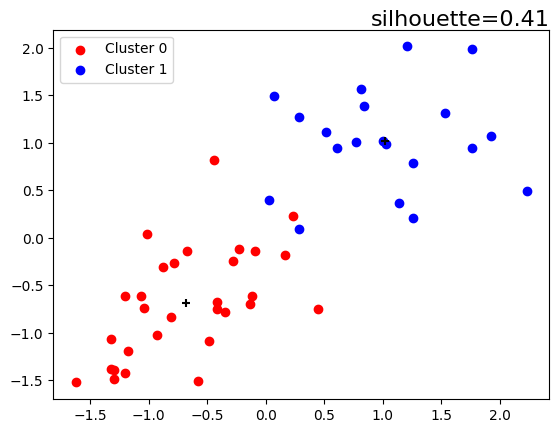

silhouette score 0.41 with K = 2


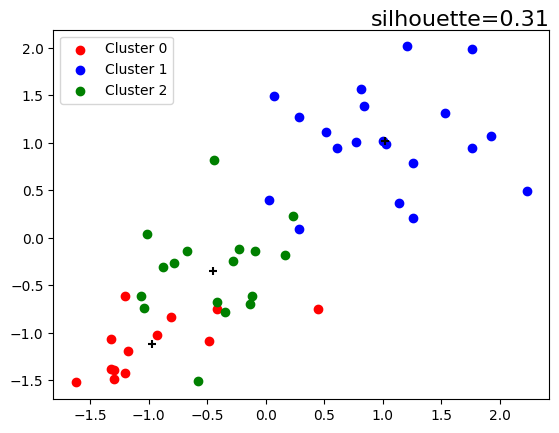

silhouette score 0.31 with K = 3


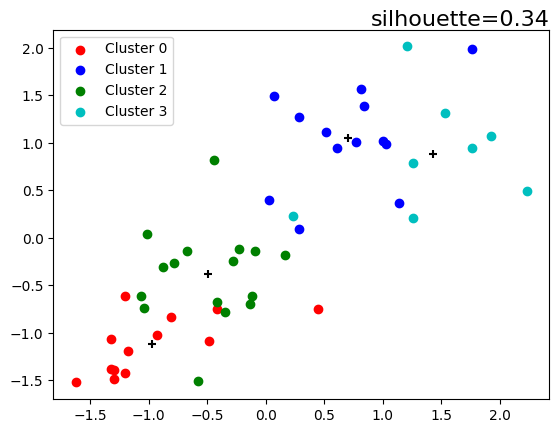

silhouette score 0.34 with K = 4


In [ ]:
def check_silhouette_score(x, k):
    kmeans = KMeans(n_clusters=k, n_init=10, init='k-means++', random_state=9)
    y_pred = kmeans.fit_predict(x)

    colours = 'rbgcmy'
    for c in range(k):
      plt.scatter(x[y_pred == c, 0], x[y_pred == c,1], c = colours[c], label = 'Cluster {}'.format(c))
      plt.scatter(kmeans.cluster_centers_[c, 0], kmeans.cluster_centers_[c, 1], marker='+', c = 'black')

    score = round(silhouette_score(x, kmeans.labels_, metric='euclidean'),2)

    plt.title('silhouette={}'.format(score), loc='right', fontdict={'fontsize': 16}, pad=-14)
    plt.legend()
    plt.show()

    return score

for k in range(2, 5):
    print(f"silhouette score {check_silhouette_score(X_scaled, k)} with K = {k}")

### K-Means Prediction

By creating a K-Means model with 2 clusters, after fitting and predicting the data, we will have two clusters that represent lower and higher crime rate. 

In [ ]:
kmeans = KMeans(n_clusters=2, n_init=10, init='k-means++', random_state=9)
y_pred = kmeans.fit_predict(X)
y_pred

array([1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1,
       0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0,
       0, 0, 0, 0, 0, 0], dtype=int32)

In [ ]:
crime_rate = pd.DataFrame(us_arrest_df["State"])
crime_rate["K-Means Crime Group"] = y_pred
crime_rate["Total Crime"] = us_arrest_df["Total Crime"]
crime_rate

,State,K-Means Crime Group,Total Crime
0,Alabama,1,270.4
1,Alaska,1,317.5
2,Arizona,1,333.1
3,Arkansas,1,218.3
4,California,1,325.6
5,Colorado,1,250.6
6,Connecticut,0,124.4
7,Delaware,1,259.7
8,Florida,1,382.3
9,Georgia,1,254.2


### Observation

The states in Cluster-0 appear to have lower crime rates, as indicated by relatively fewer occurrences of murders, assaults, and rapes. Conversely, the states in Cluster-1 appear to have higher crime rates.

### Agglomerative Clustering

Firstly, we will determine which type of linkage method is most appropriate for our data by visualizing the results.

Text(0, 0.5, 'Euclidean distances')

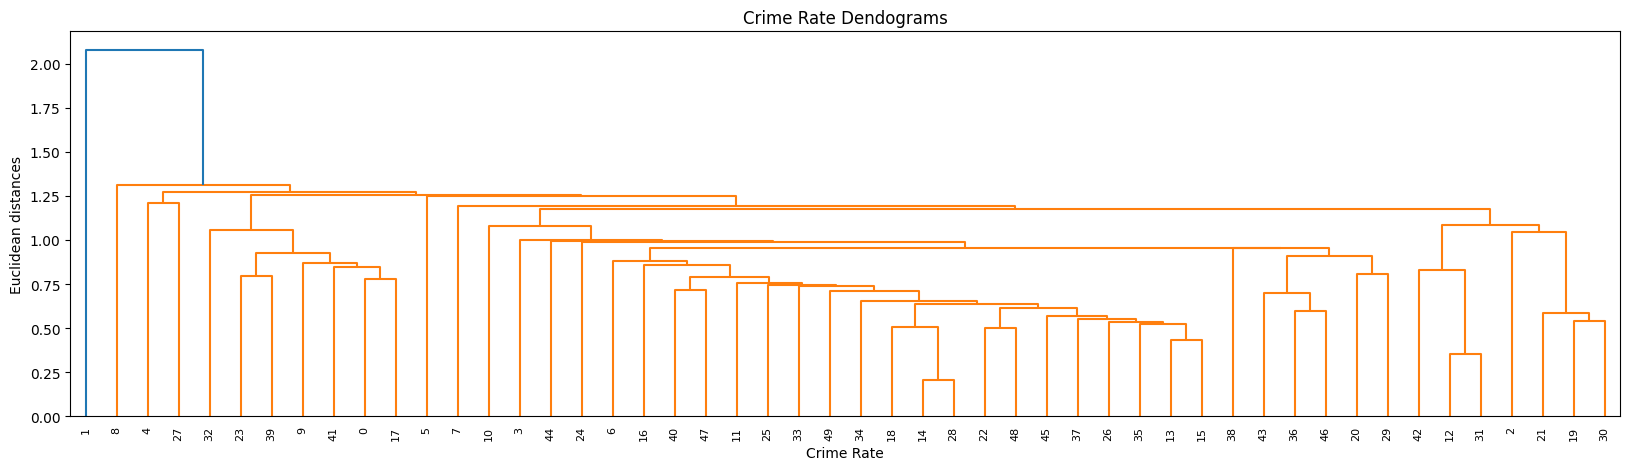

In [ ]:
# Single Leakage
plt.figure(figsize=(20,5))
plt.title("Crime Rate Dendograms")
dend = dendrogram(linkage(X_scaled, method='single'))
plt.xlabel('Crime Rate')
plt.ylabel('Euclidean distances')

Text(0, 0.5, 'Euclidean distances')

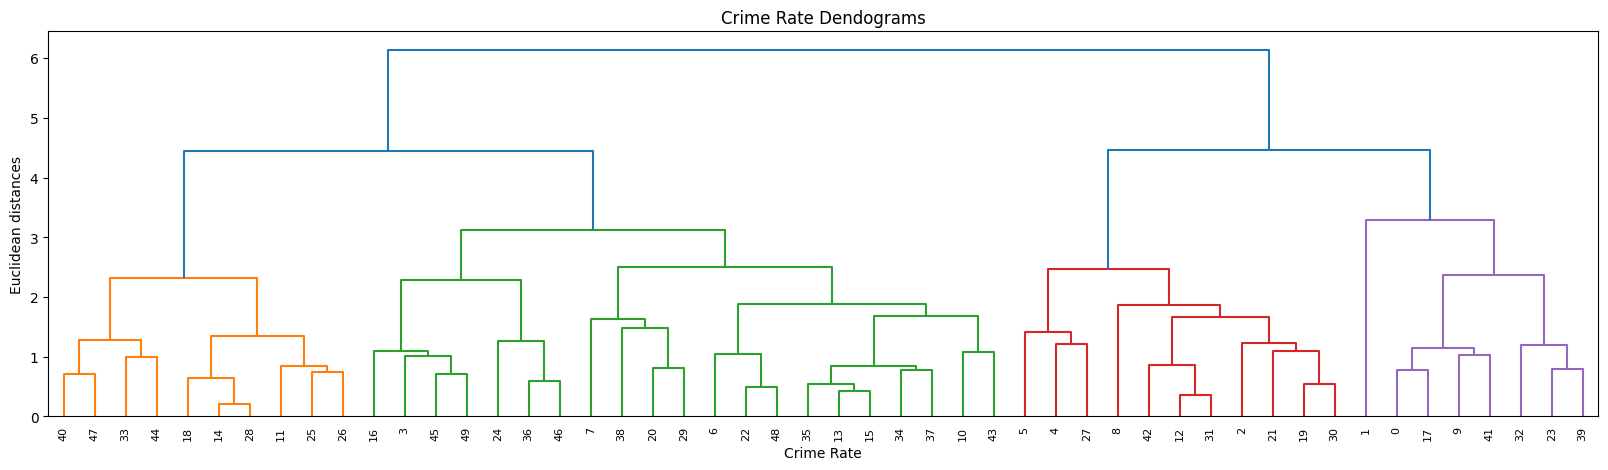

In [ ]:
# complete linkage

plt.figure(figsize=(20,5))
plt.title("Crime Rate Dendograms")
dend = dendrogram(linkage(X_scaled, method='complete'))
plt.xlabel('Crime Rate')
plt.ylabel('Euclidean distances')

Text(0, 0.5, 'Euclidean distances')

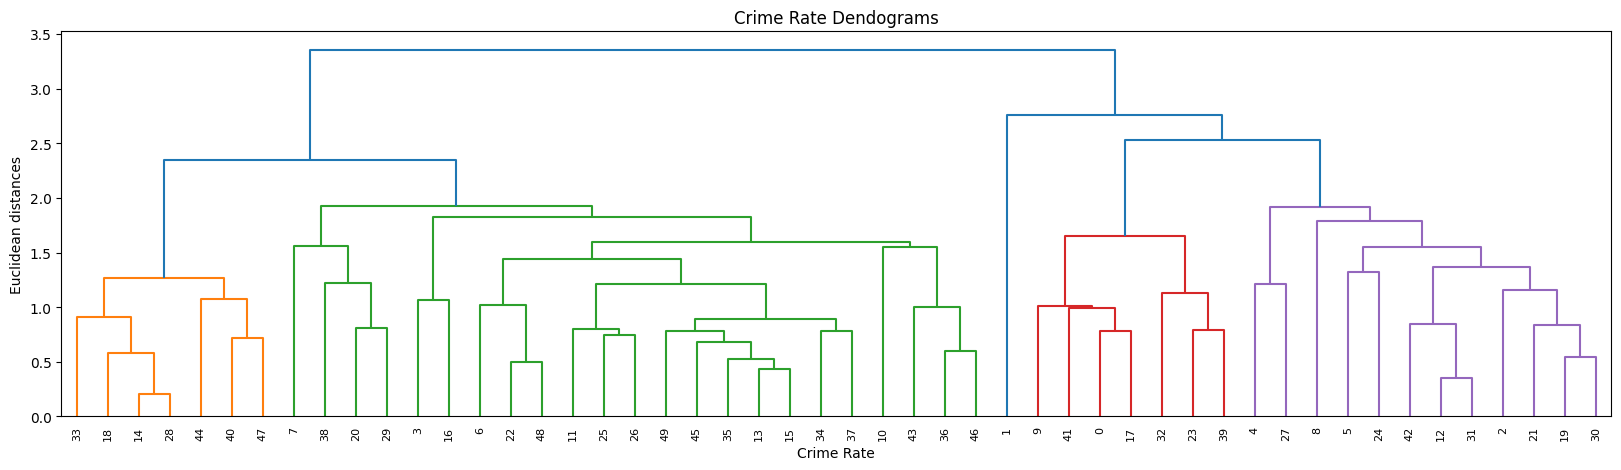

In [ ]:
# Average Linkage
plt.figure(figsize=(20,5))
plt.title("Crime Rate Dendograms")
dend = dendrogram(linkage(X_scaled, method='average'))
plt.xlabel('Crime Rate')
plt.ylabel('Euclidean distances')

The single linkage method will result in dendrograms that are poorly structured, whereas complete or average linkage methods will produce clusters with a clear tree-like structure.

In [109]:
# Create an Agglomerative Clustering with complete linkage
AC = AgglomerativeClustering(n_clusters = 2, metric = 'euclidean', linkage ='complete')


In [110]:
# Fit and predict model
y_pred =AC.fit_predict(X)
y_pred

array([1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1,
       0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0])

In [111]:
crime_rate["AC Crime Group"] = y_pred
crime_rate = crime_rate[["State", "K-Means Crime Group", "AC Crime Group", "Total Crime"]]
crime_rate

,State,K-Means Crime Group,AC Crime Group,Total Crime
0,Alabama,1,1,270.4
1,Alaska,1,1,317.5
2,Arizona,1,1,333.1
3,Arkansas,1,0,218.3
4,California,1,1,325.6
5,Colorado,1,0,250.6
6,Connecticut,0,0,124.4
7,Delaware,1,1,259.7
8,Florida,1,1,382.3
9,Georgia,1,0,254.2


### Observation

The predictions made by K-means and Agglomerative Clustering mostly align with one another, however, there may be some slight differences between the two.

Let's evaluate the quality of the clustering solution obtained through Agglomerative Clustering by calculating the silhouette score and comparing it to the score obtained from K-Means.

In [113]:
score = round(silhouette_score(X, y_pred, metric='euclidean'),2)
print(f"Silhouette score for AC: {score}")


Silhouette score for AC: 0.58


After evaluating the clustering solutions obtained through both Agglomerative Clustering and K-Means, we find that Agglomerative Clustering has a higher silhouette score of 0.58 compared to the K-Means score of 0.41. This suggests that Agglomerative Clustering is a better model for this dataset.

All the work has been push to the following github repo

https://github.com/lifefir3/hyperiondev-ds-task51